In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Wave_propogation

/content/drive/My Drive/Wave_propogation


In [ ]:

# a = torch.randn(4, 3, 2, 2)
# res = a.view(a.shape[0] * a.shape[1], -1)
# torch.norm(res, p=np.Inf, dim=1).shape

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

import torch
from PIL import Image
import torchvision.transforms as transforms

# from utils import  Simulation, get_vp, ParamsGenerator

from train_utils import get_batch, train, validate#, test
from plottings import show_grig
from IPython.display import clear_output
from time import gmtime, strftime
from utils import save_model, model_best, load_model

import torch, torch.nn as nn
import torch.nn.functional as F

from models import WaveAE, WaveGRUModel, WaveLSTMModel
from losses import WaveLoss
import torch, torch.nn as nn

from torch import optim 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
!pip install GPUtil

In [80]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
device

'cuda'

In [81]:
batch_size = 8
n_epochs = 1000
# n_epochs = 400
n_batches_per_epoch = 10
n_validation_batches = 5

In [82]:


N_min = 4.
N_max = 6.

nx, nz, nt = 80, 80, 25

# model = WaveAE(in_channels=1, bottle_neck=32, n_layers=2, kernel_size=3,
#               pooling=nn.MaxPool2d, activation=nn.ELU, pruning=True)

h_control = {'ord': 'l1', 'lam': 0.}
# 
# model = WaveGRUModel(bottle_neck=32, rnn_channels=32, n_layers=2, kernel_size=3,
#                      pooling=nn.MaxPool2d, activation=nn.ELU, pruning=True, 
#                      mode='fast', hidden_control=h_control)


model = WaveLSTMModel(bottle_neck=32, rnn_channels=32, n_layers=2, kernel_size=3,
                     pooling=nn.MaxPool2d, activation=nn.ELU, pruning=False, 
                     mode='fast', hidden_control=h_control)

model.to(device)

#loss = nn.MSELoss()
#loss = nn.L1Loss()

loss = WaveLoss(order='inf', factor=None)

# alpha = nn.Parameter(torch.Tensor([1.]), requires_grad=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
#add_name = 'AE/pruning_MaxPool2d_ELU'

#add_name = 'final/pruning_ELU_MaxPool2d_fast_'
#add_name = 'fast_ELU_pruning_MaxPool2d_'

add_name = 'LSTM_TRY_no_pruning_L1'
#GPUtil.showUtilization()

In [83]:
import gc
# del batch
gc.collect()
torch.cuda.empty_cache()

#GPUtil.showUtilization()

In [84]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)#, weight_decay=1e-4)

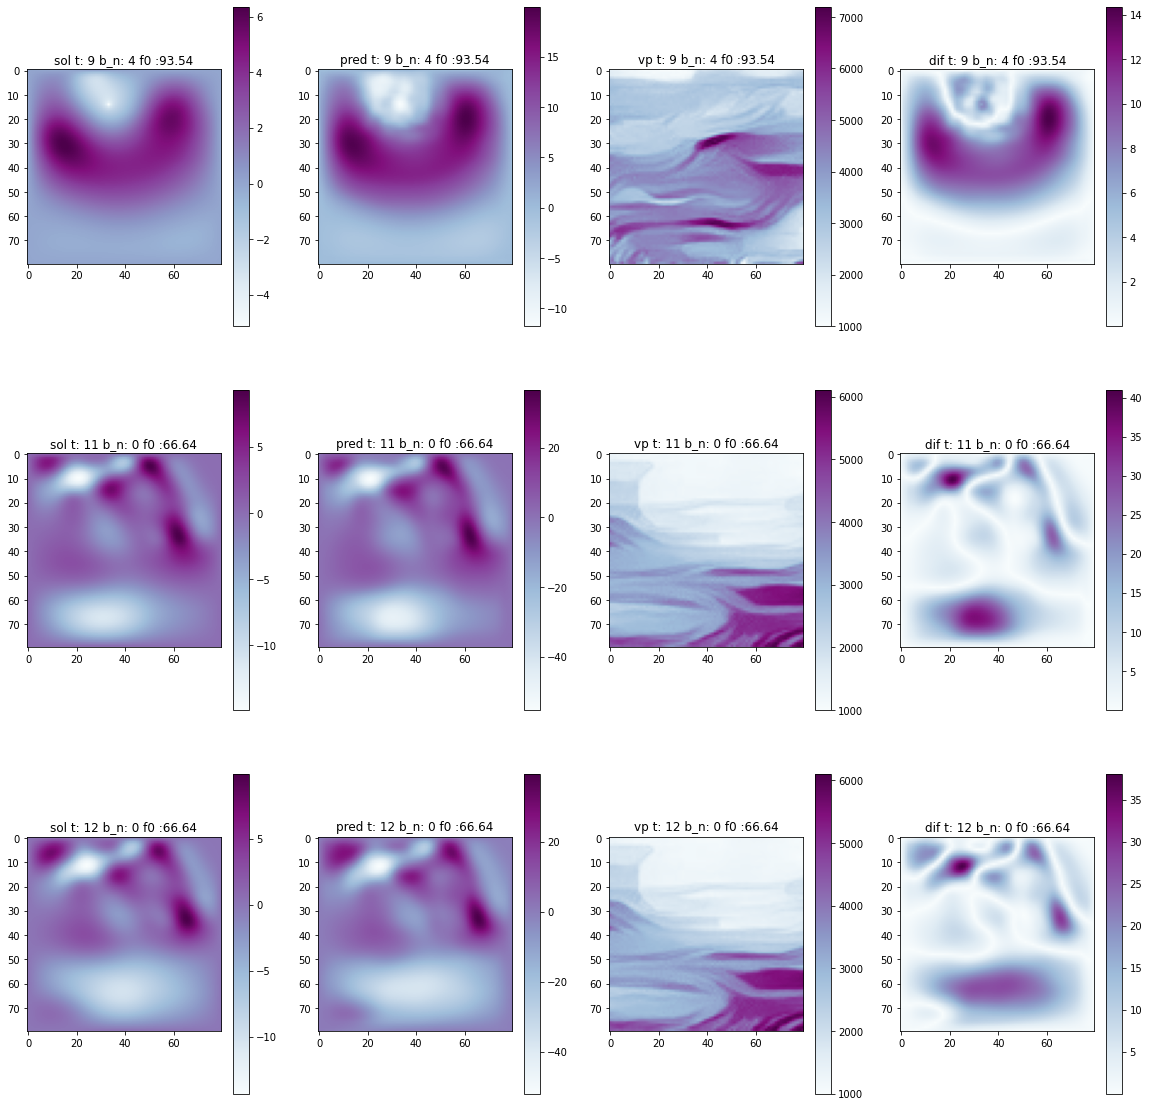



Epoch: 25, train loss: 0.735526156425476, val loss: 0.7942362904548645


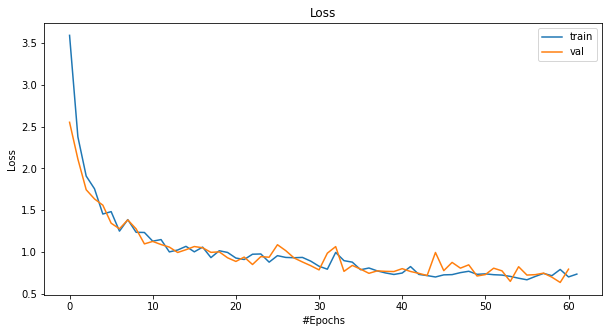

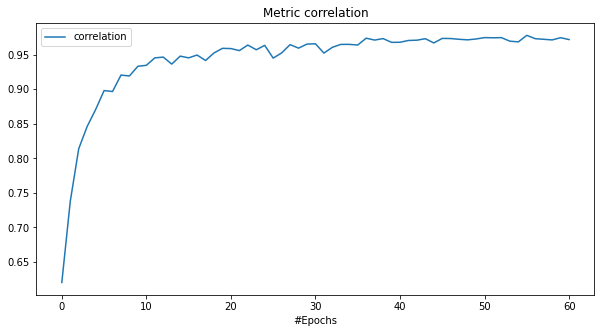

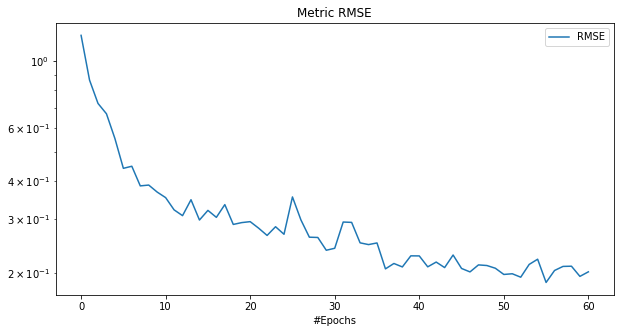

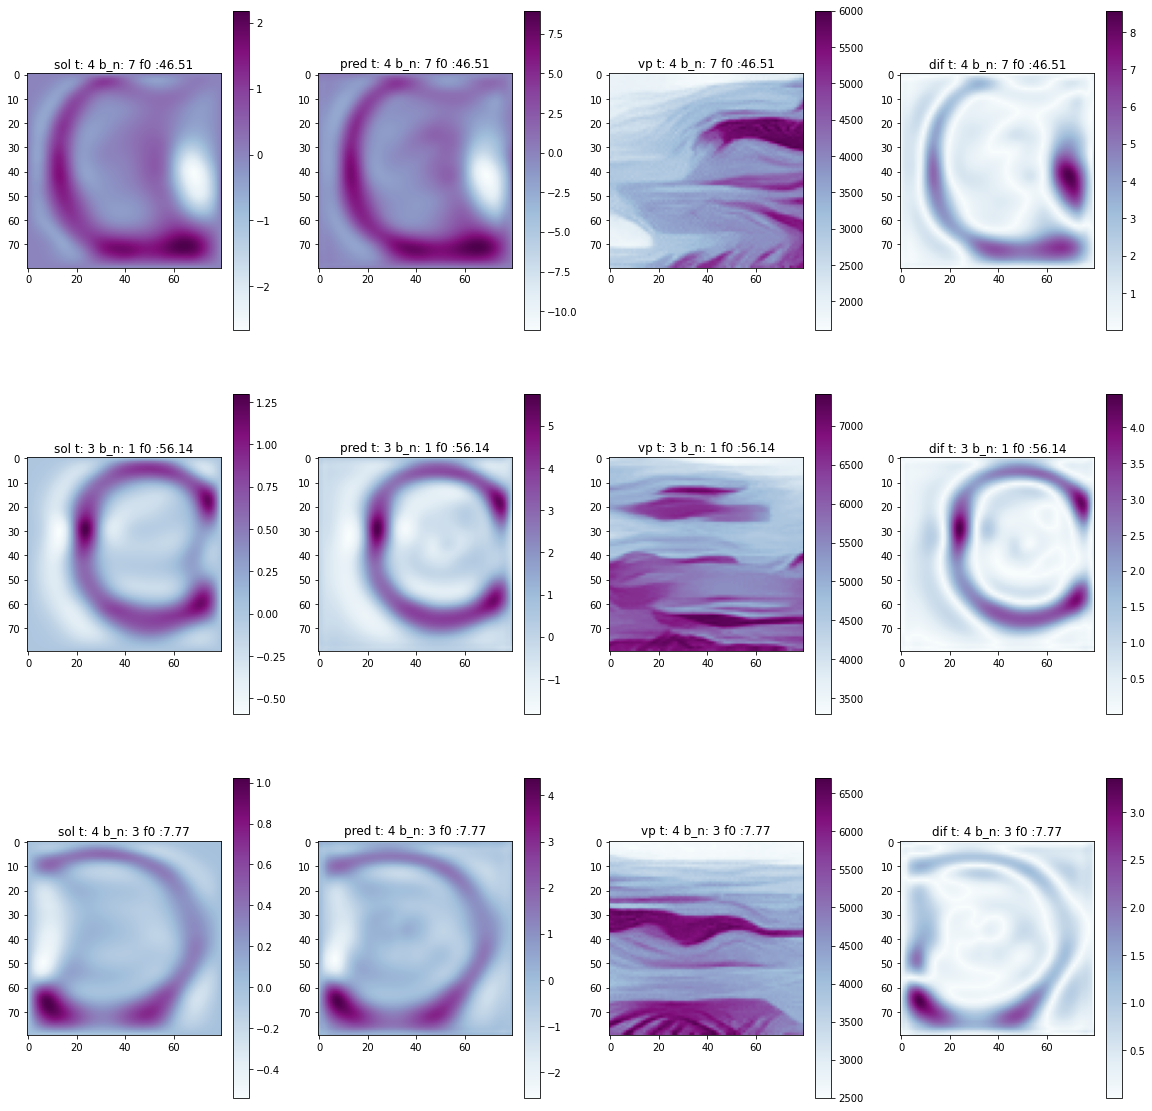



Epoch: 26, train loss: 0.7220777213573456, val loss: 0.6680042028427124


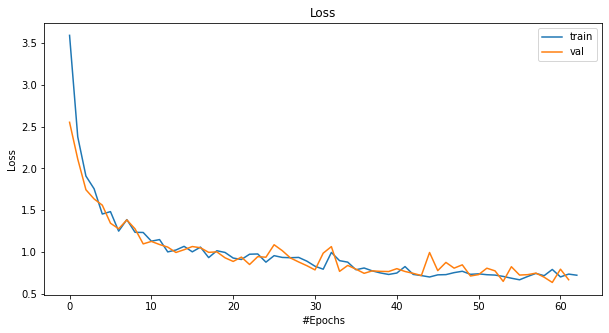

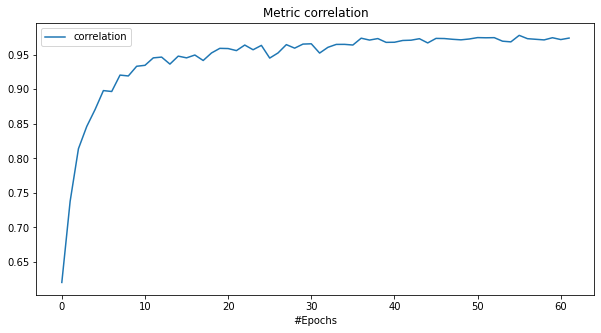

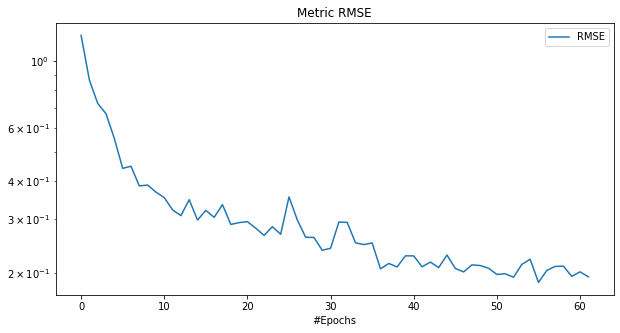

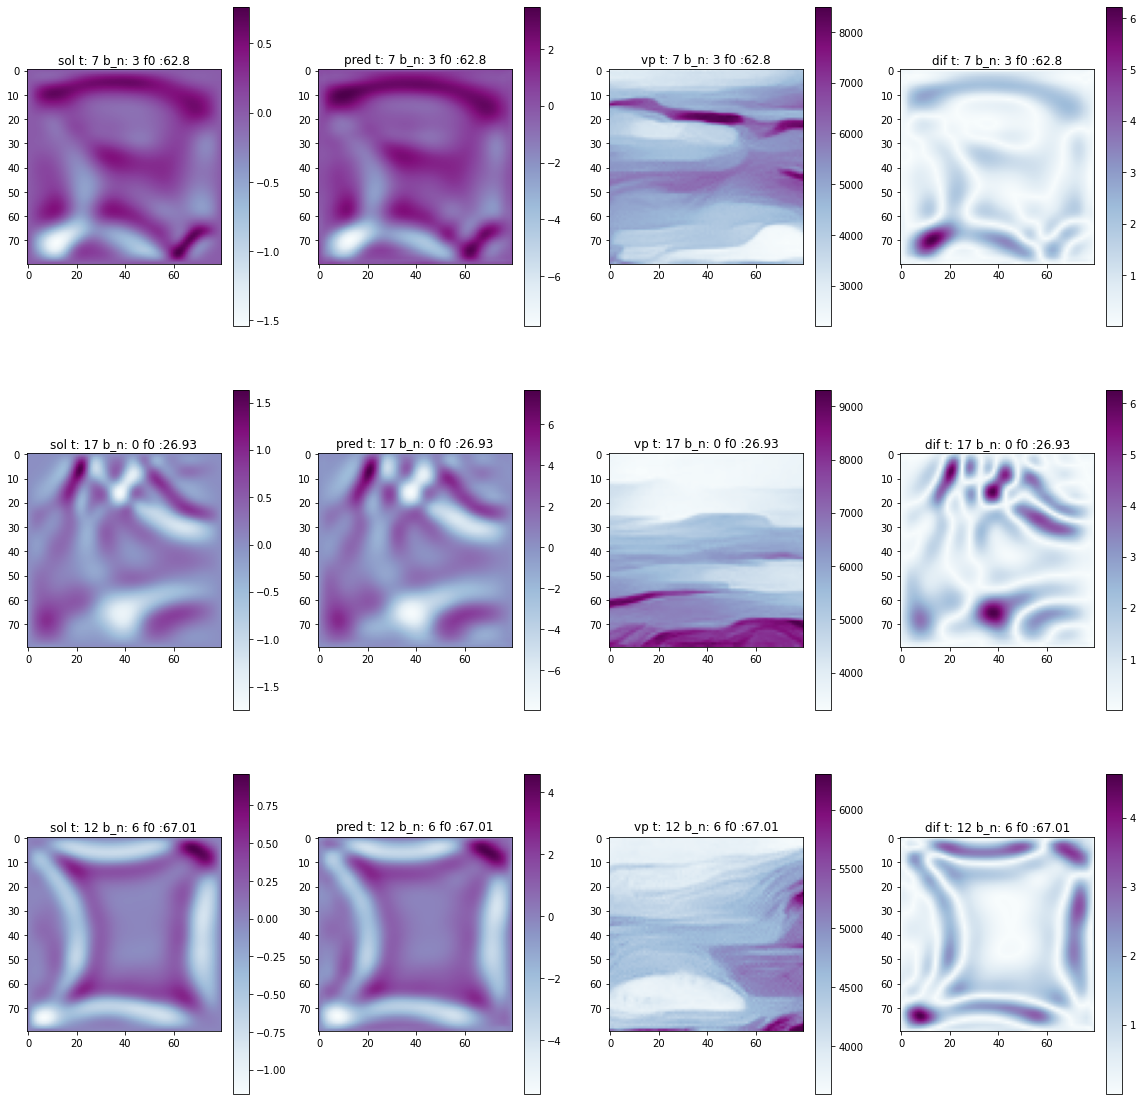



Epoch: 27, train loss: 0.6715271174907684, val loss: 0.77426518201828


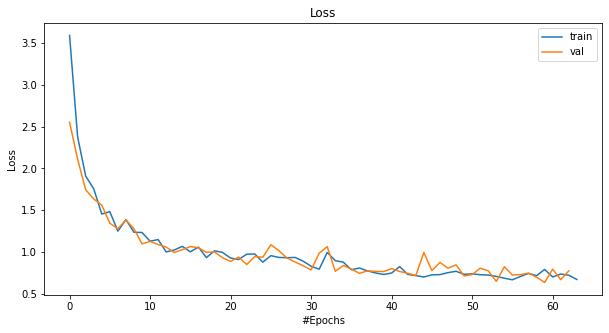

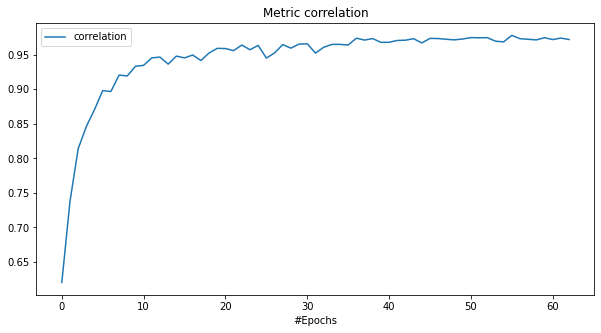

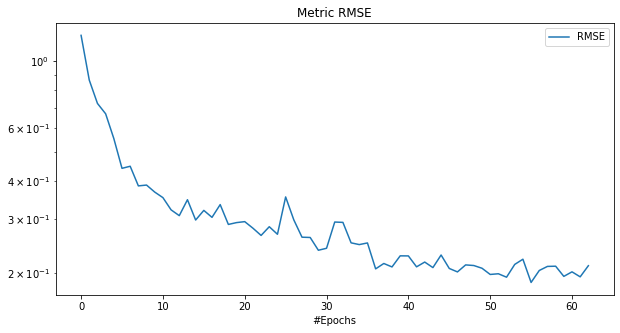

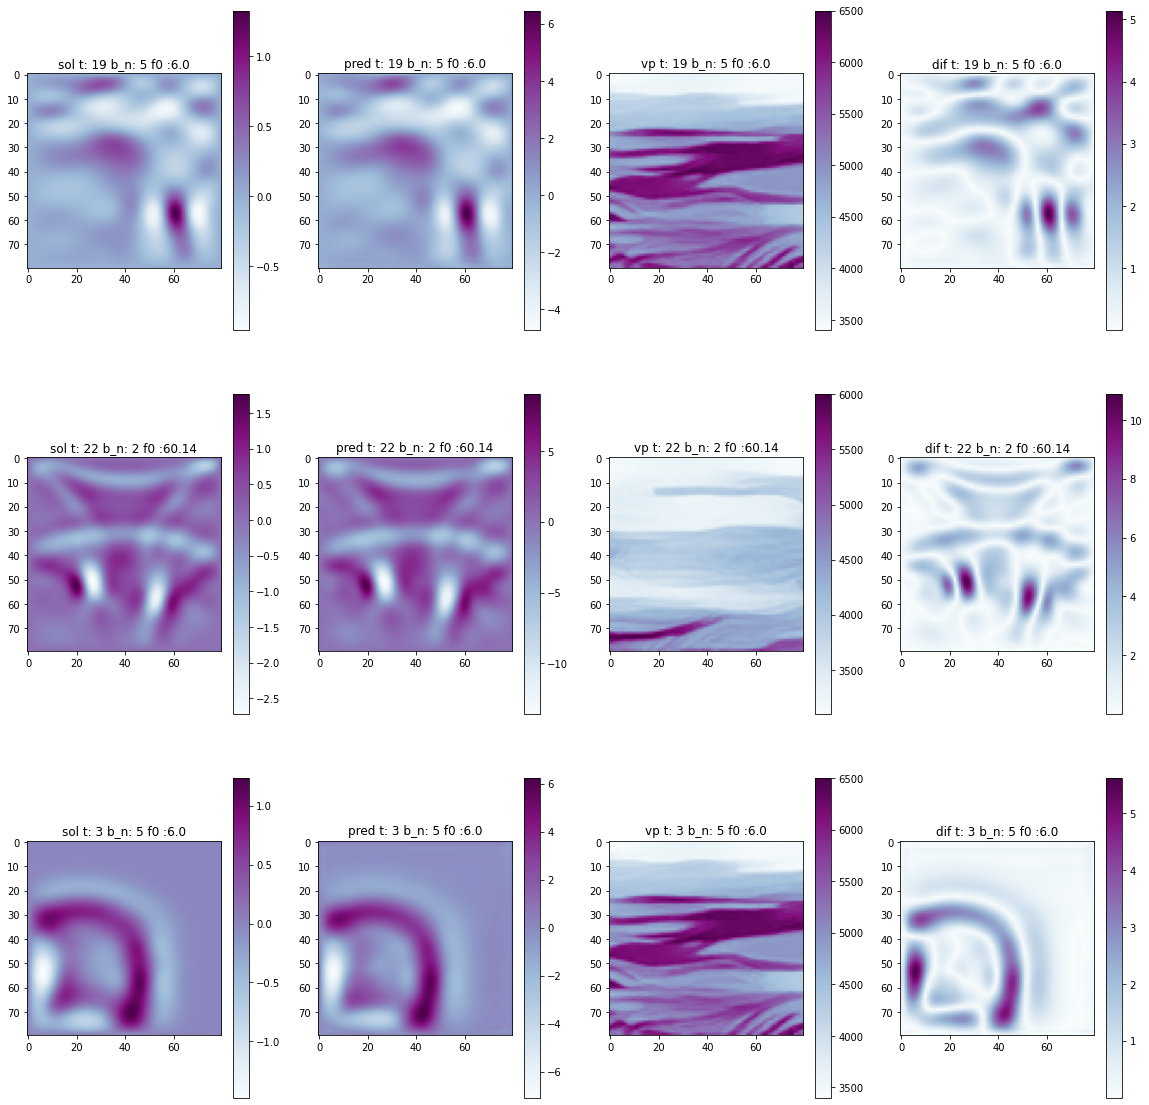




...
KeyboardInterrupt error: model saving started!
Parameters of the model and optimizer are saved to file --> ./checkpoints/LSTM_TRY_no_pruning_L1WaveLSTMModel_KeyboardInterrupt_2020-12-06 14:21:03.pth
Parameters of the model and optimizer are saved to file --> ./checkpoints/LSTM_TRY_no_pruning_L1_LAST_WaveLSTMModel_KeyboardInterrupt_2020-12-06 14:21:03.pth


In [ ]:
from plottings import plot_metrics
# loss_hist = {'train': [],
#              'val': []}

# metrix_coeff = {'correlation': [],
#                 'RMSE': []}

# epoch_time_nn = []
# epoch_time_fd = []

# factors = []

try :
  for epoch in tqdm(range(n_epochs)):
    
    train(model, optimizer, loss_hist, epoch_time_nn, N_min, N_max, nx, nz, nt,
            epoch_time_fd, n_batches_per_epoch, batch_size, device, loss, factors)#, scheduler)
    
    if epoch % 5 == 0:
      clear_output()

    validate(model, optimizer, loss_hist, n_validation_batches, 
            device, N_min, N_max, nx, nz, nt, loss, batch_size, metrix_coeff)
    
    # plot_metrics(model, epoch, loss_hist, epoch_time_nn, epoch_time_fd, metrix_coeff)
    plot_metrics(model, epoch, loss_hist, metrix_coeff)

    # check for best model
    result = model_best(loss_hist, metrix_coeff)
    # print(result)
    if result != []:
      # print("Yes")
      save_model(epoch, model, optimizer, loss_hist, metrix_coeff, best_names=result, KI=False, add_name=add_name)

except KeyboardInterrupt:
  print('\n\n\n...\nKeyboardInterrupt error: model saving started!')
  save_model(epoch, model, optimizer, loss_hist, metrix_coeff, best_names=[], KI=True, add_name=add_name)  

save_model(epoch, model, optimizer, loss_hist, metrix_coeff, best_names=[], KI=True, add_name=add_name+'_LAST_')

In [ ]:
# save_model(epoch, model, optimizer, loss_hist, metrix_coeff, best_names=[], KI=True, add_name=add_name+'_LAST_')


Epoch: 379, train loss: 0.19153904691338539, val loss: 0.10796433240175247
(tensor(30.5556), 144, tensor([0.0535], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(56.8359), 4608, tensor([0.0238], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(18.7500), 144, tensor([0.0372], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(26.6059), 4608, tensor([0.0016], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(32.4002), 4608, tensor([0.0052], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(34.7222), 144, tensor([0.1018], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(51.9911), 18432, tensor([0.0032], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(52.0345), 18432, tensor([0.0036], device='cuda:0', grad_fn=<SigmoidBackward>))


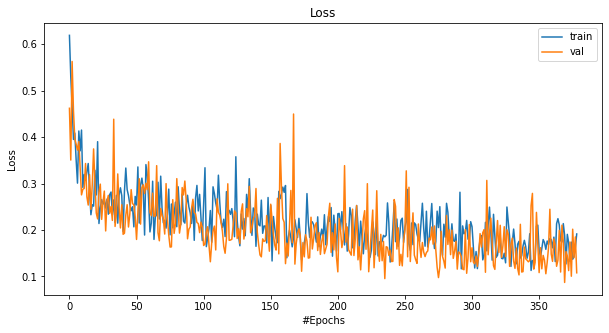

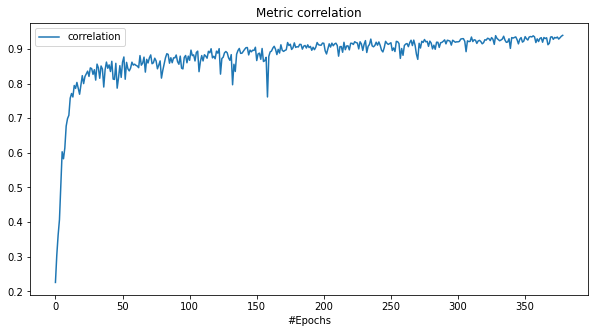

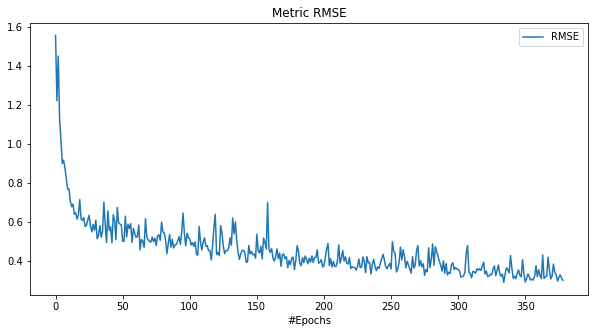

In [ ]:
from plottings import plot_metrics
from utils import load_metrics

plot_metrics(model, epoch, loss_hist, metrix_coeff)


Epoch: 29, train loss: 0.6958340287208558, val loss: 0.77426518201828


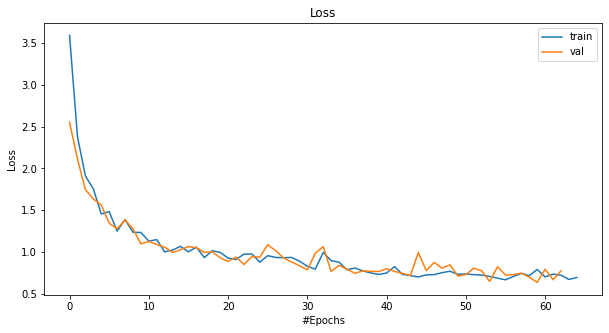

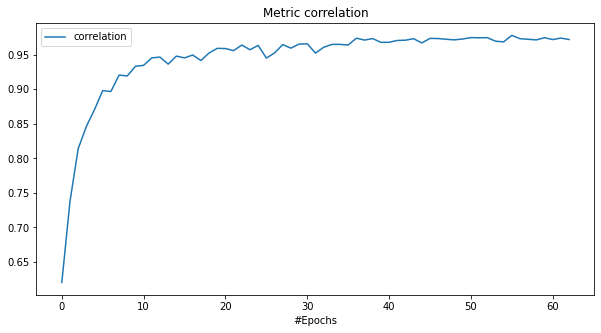

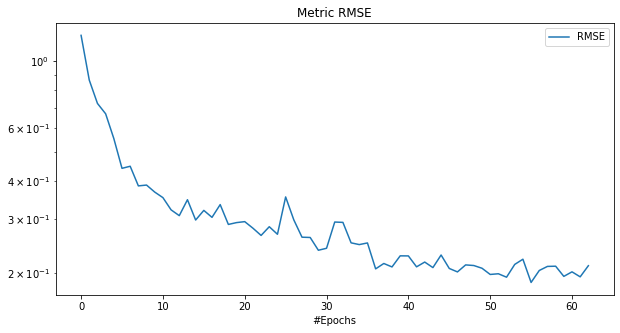

In [85]:
############## some pictures #######################

# model = WaveAE(in_channels=1, bottle_neck=32, n_layers=2, kernel_size=3,
#               pooling=nn.MaxPool2d, activation=nn.Tanh, pruning=False)

# model = WaveGRUModel(bottle_neck=32, n_layers=2, kernel_size=3,
#                pooling=nn.MaxPool2d, activation=nn.ELU, pruning=False, mode='fooo')

# model.to(device)

#loss = nn.MSELoss()
# loss = nn.L1Loss()

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-4)

epoch = 5
loss_hist = {'train': [],
             'val': []}

metrix_coeff = {'correlation': [],
                'RMSE': []}

epoch_time_nn = [1]
epoch_time_fd = [1]


# loss_hist, metrix_coeff, epoch = load_model('./checkpoints/RNN/no_pruning_MaxPool2d_ELU_fooo__LAST_WaveGRUModel_KeyboardInterrupt_2020-11-21 21_24_30.pth', model, optimizer, loss_hist, metrix_coeff)
loss_hist, metrix_coeff, epoch = load_model('./checkpoints/LSTM_TRY_no_pruning_L1_LAST_WaveLSTMModel_KeyboardInterrupt_2020-12-06 14:21:03.pth', model, optimizer, loss_hist, metrix_coeff)
plot_metrics(model, epoch, loss_hist, metrix_coeff)

last_state_list  2
last_state_list  2


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


last_state_list  2
last_state_list  2


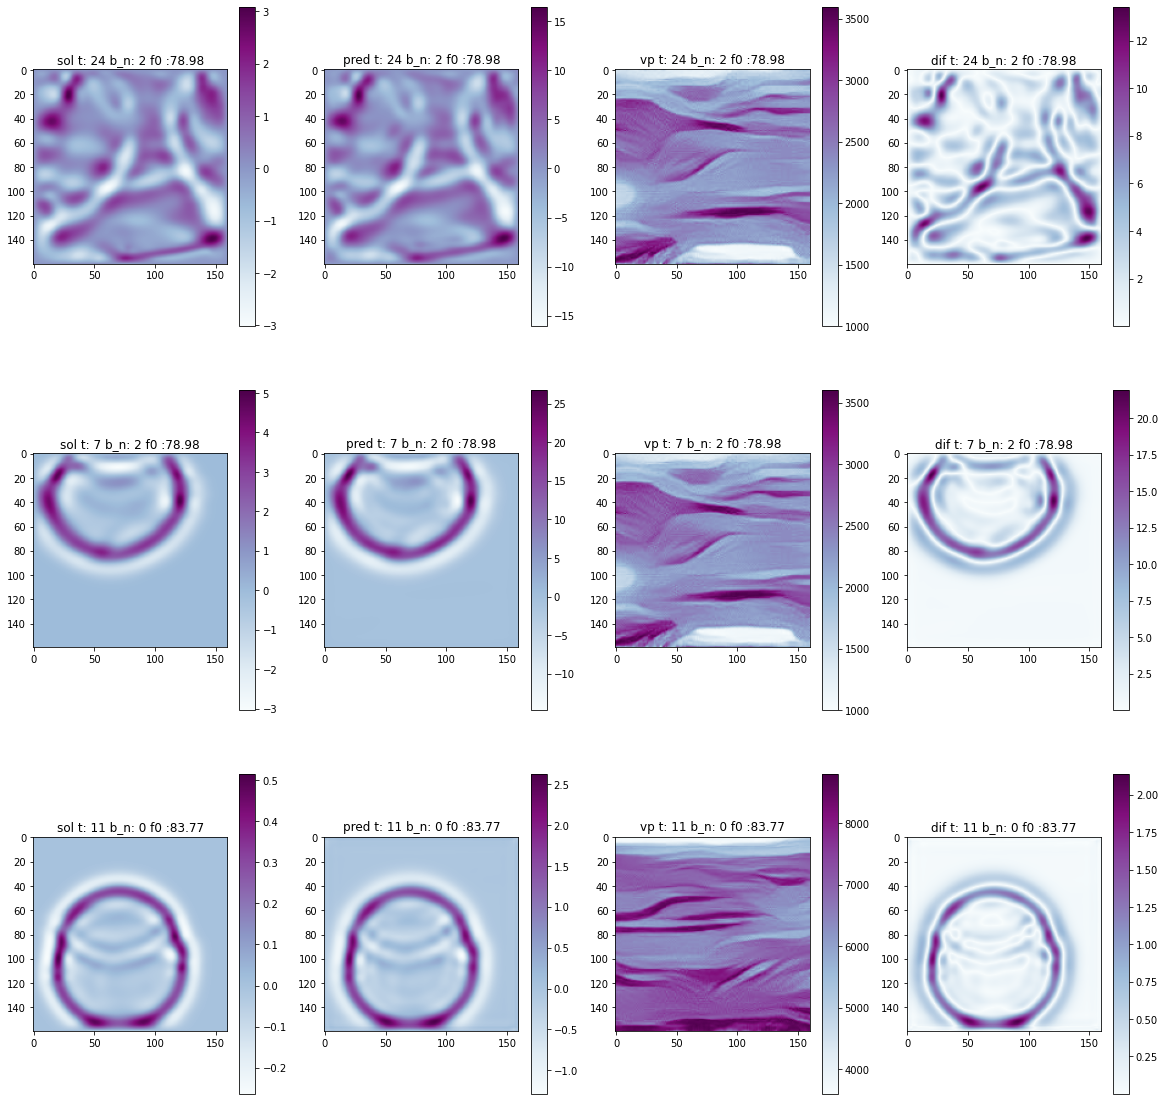

last_state_list  2
last_state_list  2
last_state_list  2
last_state_list  2
last_state_list  2
last_state_list  2



In [86]:
validate(model, optimizer, loss_hist, n_validation_batches, 
            device, N_min, N_max, nx*2, nz*2, nt*2, loss, batch_size, metrix_coeff)

In [93]:

from plottings import plot_test_video
from test import test_model_model, test_diff_model, test_diff_model__

In [ ]:
# #path_to_model = './checkpoints/RNN/no_pruning_MaxPool2d_ELU_fooo_WaveGRUModel_best_val_best_correlation.pth'
#  path_to_model = './checkpoints/foooooWaveGRUModel_best_correlation.pth'
# tester = Test(path_to_model, optimizer, model, device)

In [88]:
device

'cuda'

In [89]:
# model_1 = WaveAE(in_channels=1, bottle_neck=32, n_layers=2, kernel_size=3,
#               pooling=nn.MaxPool2d, activation=nn.ELU, pruning=True)
# path_model_1 = './checkpoints/first_3_pictures_MaxPool2d_ELU_pruning_factor_l1WaveAE_KeyboardInterrupt_2020-12-06 01:12:54.pth'


# h_control = {'ord': 'l1', 'lam': 0.}
# model_2 = WaveGRUModel(bottle_neck=32, rnn_channels=32, n_layers=2, kernel_size=3,
#                      pooling=nn.MaxPool2d, activation=nn.ELU, pruning=True, 
#                      mode='fast', hidden_control=h_control)

# path_model_2 = './checkpoints/fooo_WaveGRUModel_best_correlation.pth'

# model_1.to(device)
# model_2.to(device)

In [90]:
# epoch = 5
# loss_hist = {'train': [],
#              'val': []}

# metrix_coeff = {'correlation': [],
#                 'RMSE': []}

# epoch_time_nn = [1]
# epoch_time_fd = [1]
# optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-3)
# loss_hist, metrix_coeff, epoch = load_model(path_model_1, model_1, optimizer, loss_hist, metrix_coeff)
# loss_hist, metrix_coeff, epoch = load_model(path_model_2, model_2, optimizer, loss_hist, metrix_coeff)

In [ ]:

# predictions, u_labels, vp, f0_list = test_model_model(model_1, model_2, N_min=4, N_max=6, nx=80, nz=80, nt=50, batch_size=2, device=device)
# plot_test_video(u_labels, predictions, vp, f0_list)

X  torch.Size([2, 10, 148, 148])
p  torch.Size([2, 10, 148, 148])
P  torch.Size([2, 19, 148, 148])
X1  torch.Size([2, 11, 148, 148])
X  torch.Size([2, 11, 148, 148])
p  torch.Size([2, 11, 148, 148])
P  torch.Size([2, 19, 148, 148])
X1  torch.Size([2, 12, 148, 148])
X  torch.Size([2, 12, 148, 148])
p  torch.Size([2, 12, 148, 148])
P  torch.Size([2, 19, 148, 148])
X1  torch.Size([2, 13, 148, 148])
X  torch.Size([2, 13, 148, 148])
p  torch.Size([2, 13, 148, 148])
P  torch.Size([2, 19, 148, 148])
X1  torch.Size([2, 14, 148, 148])
X  torch.Size([2, 14, 148, 148])
p  torch.Size([2, 14, 148, 148])
P  torch.Size([2, 19, 148, 148])
X1  torch.Size([2, 15, 148, 148])
X  torch.Size([2, 15, 148, 148])
p  torch.Size([2, 15, 148, 148])
P  torch.Size([2, 19, 148, 148])
X1  torch.Size([2, 16, 148, 148])
X  torch.Size([2, 16, 148, 148])
p  torch.Size([2, 16, 148, 148])
P  torch.Size([2, 19, 148, 148])
X1  torch.Size([2, 17, 148, 148])
X  torch.Size([2, 17, 148, 148])
p  torch.Size([2, 17, 148, 148])
P  

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


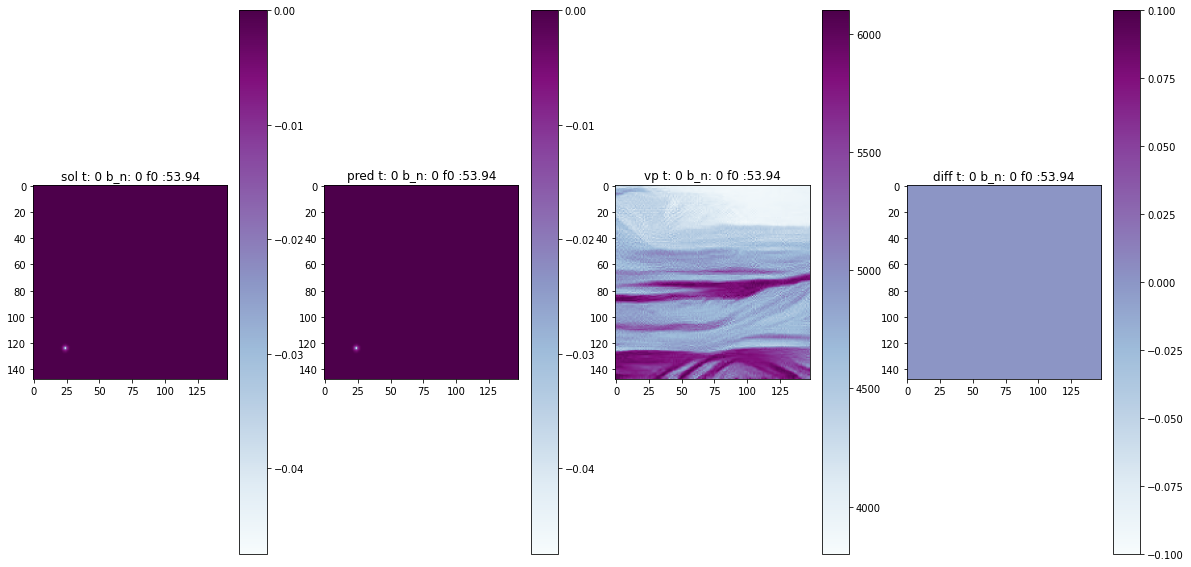

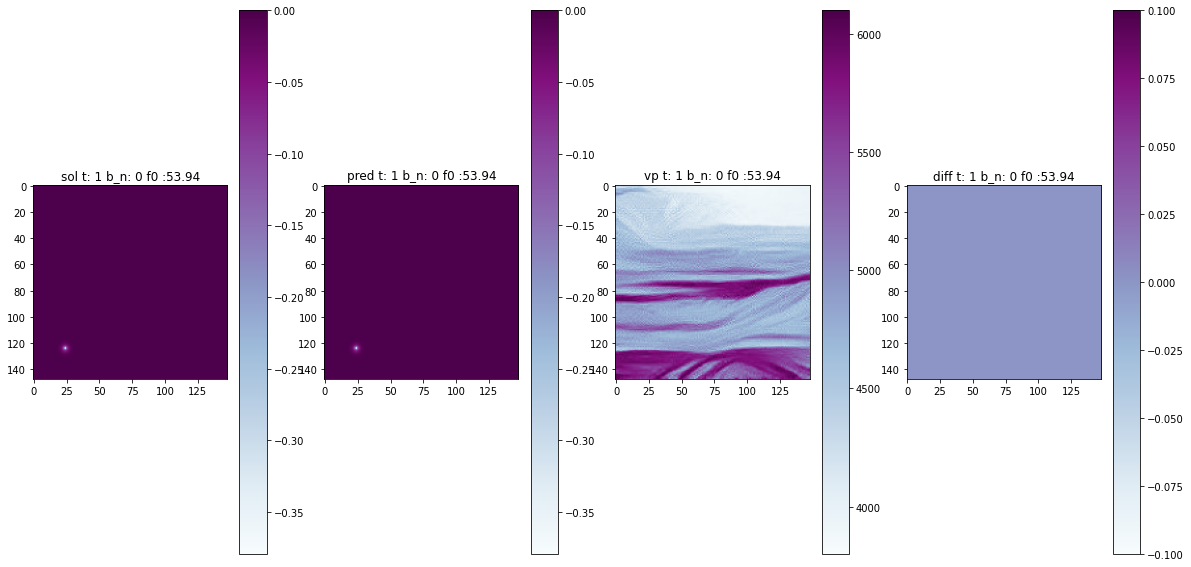

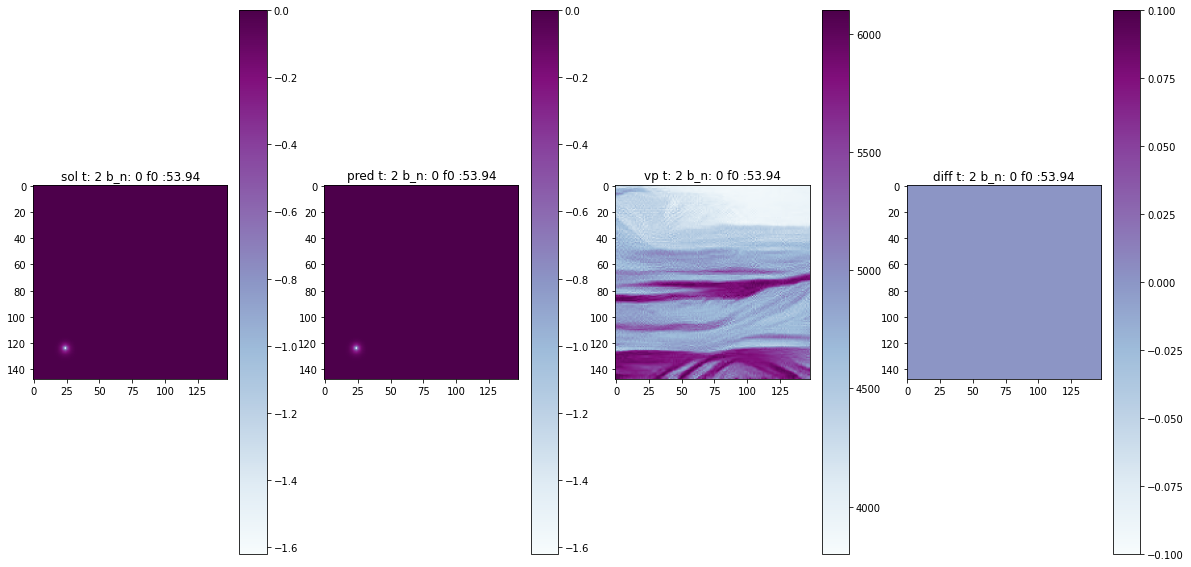

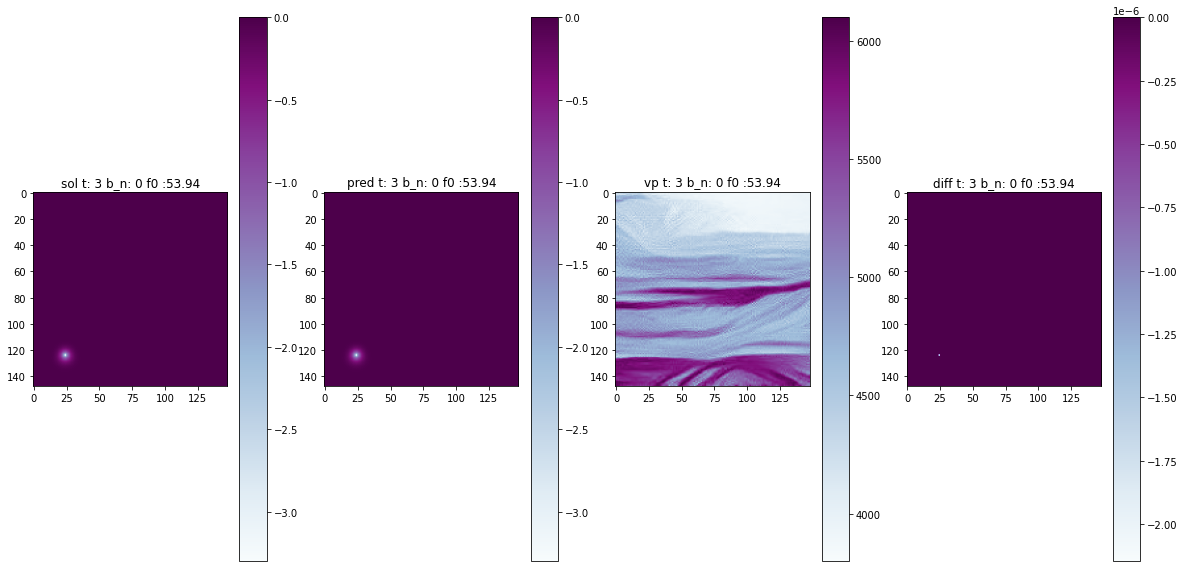

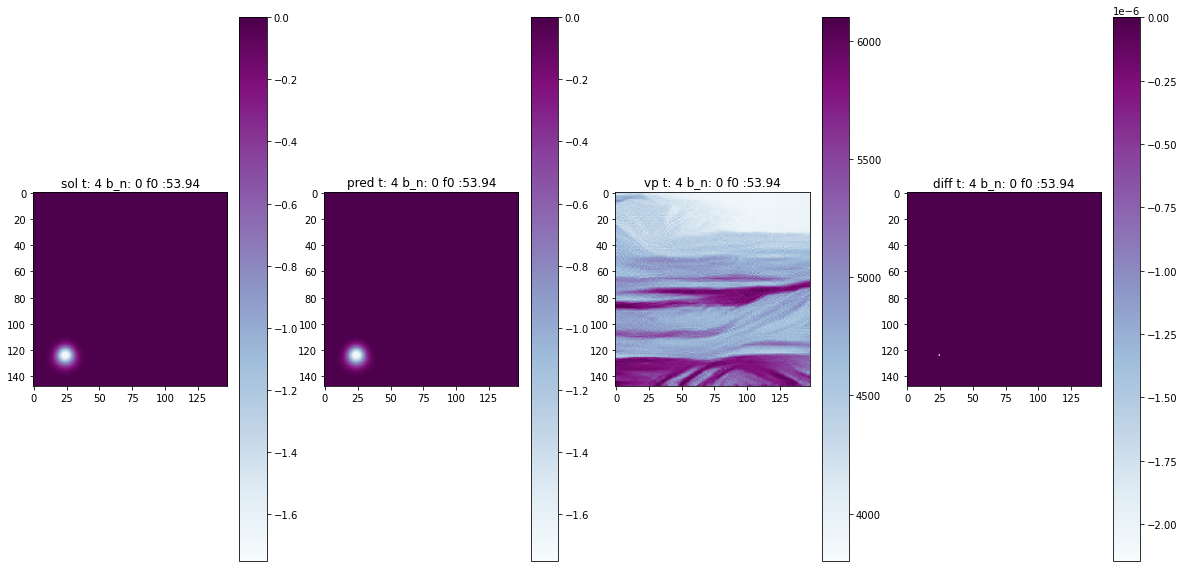

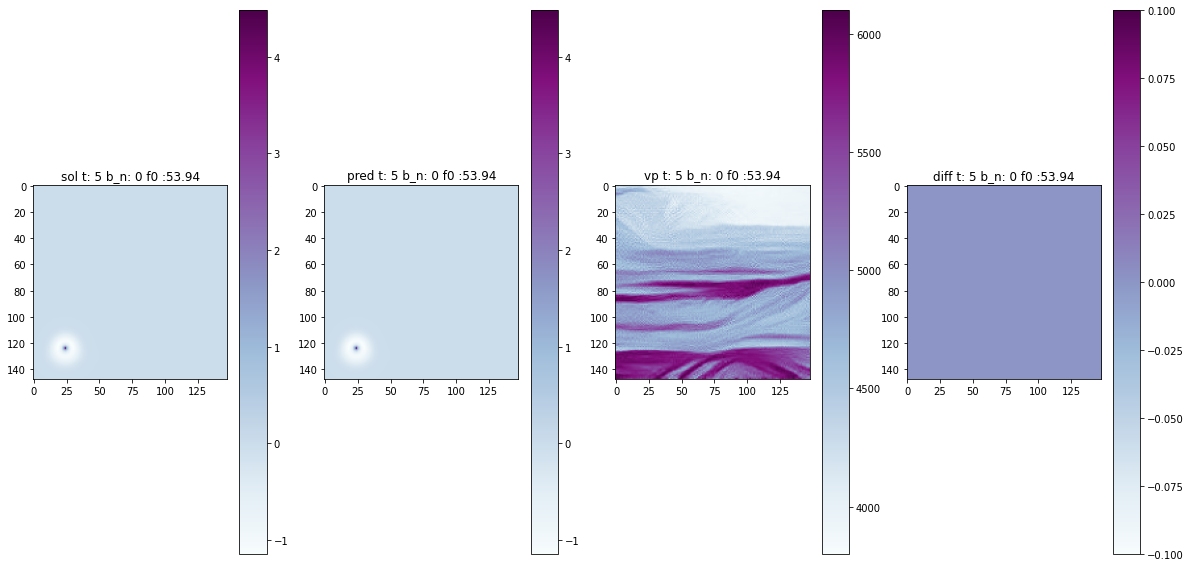

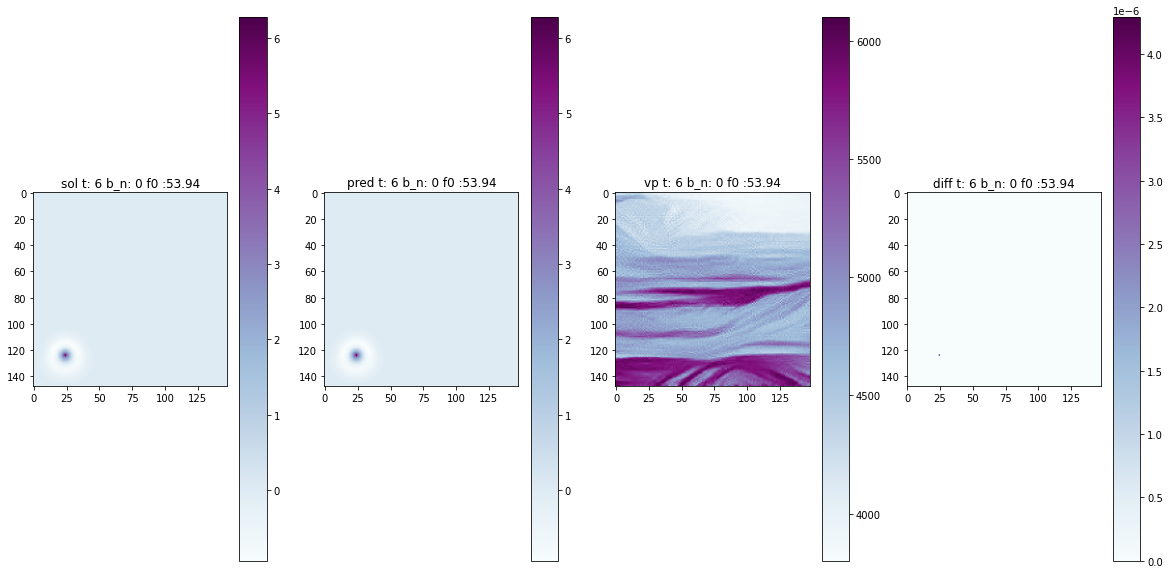

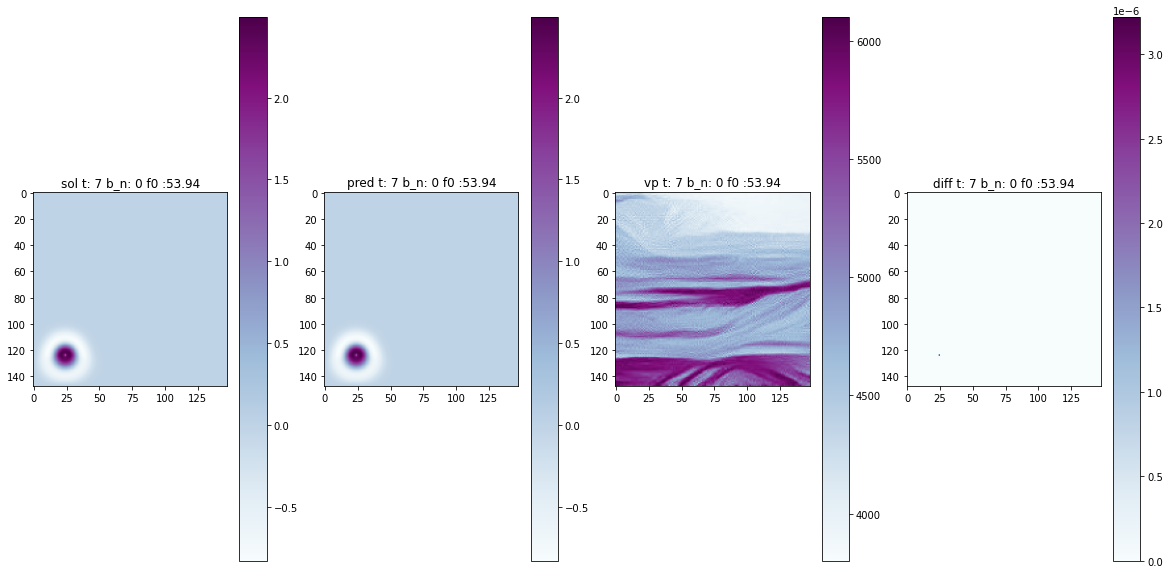

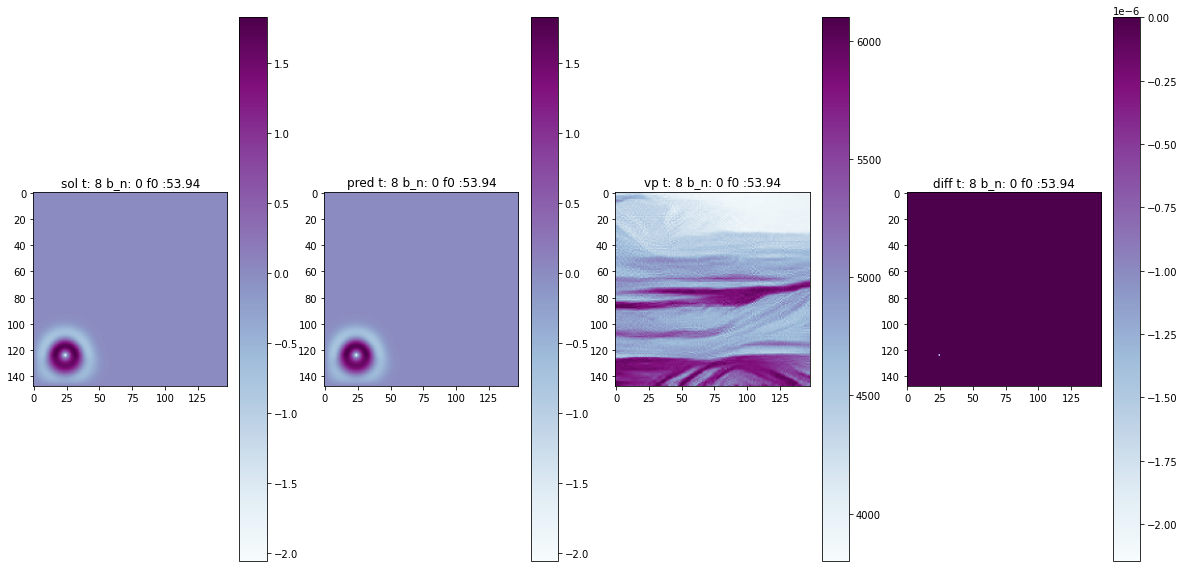

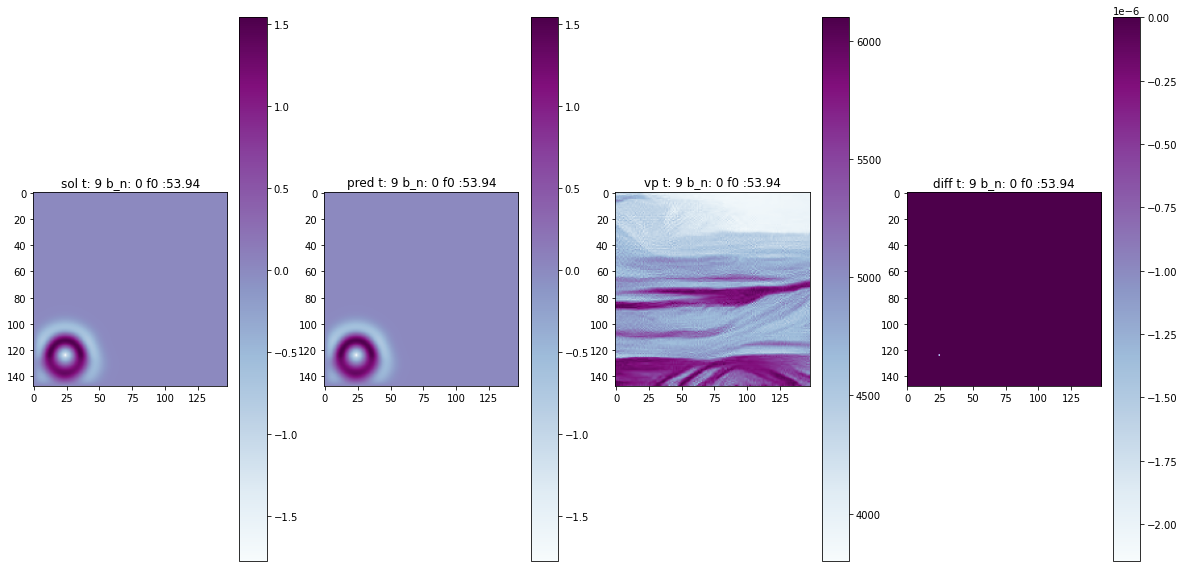

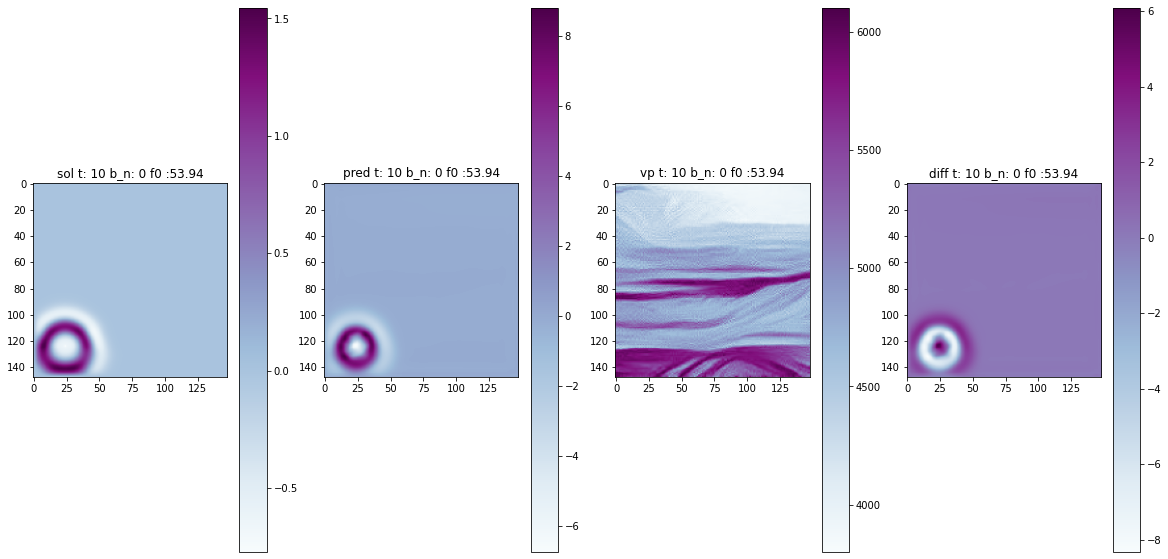

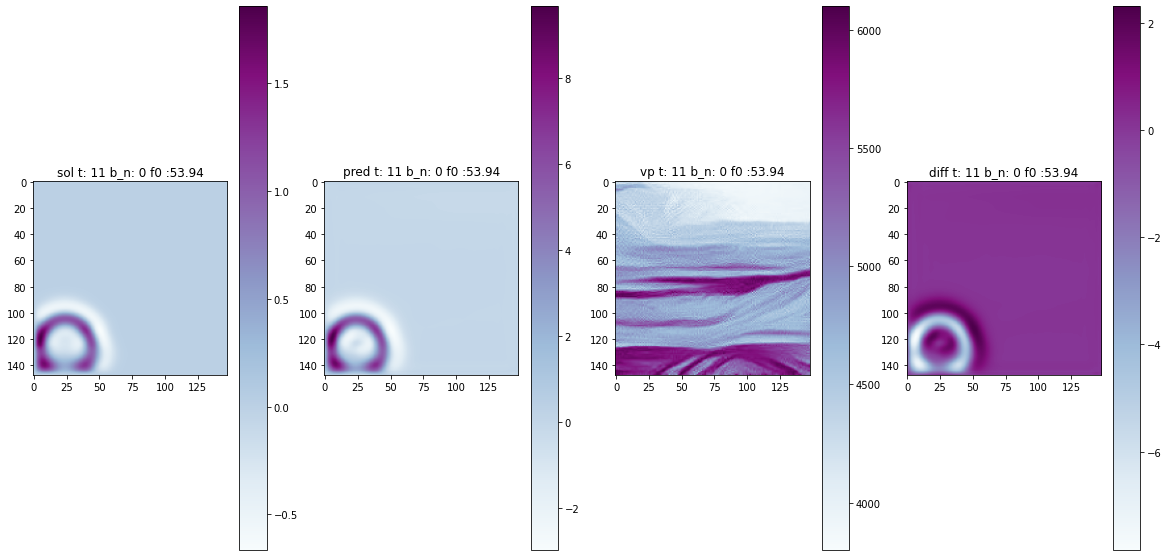

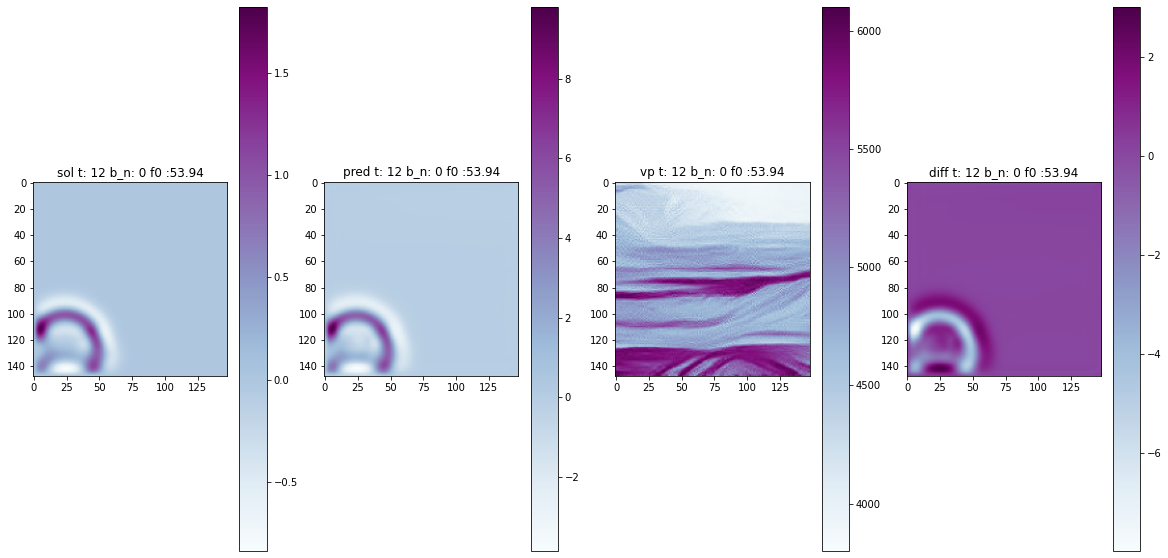

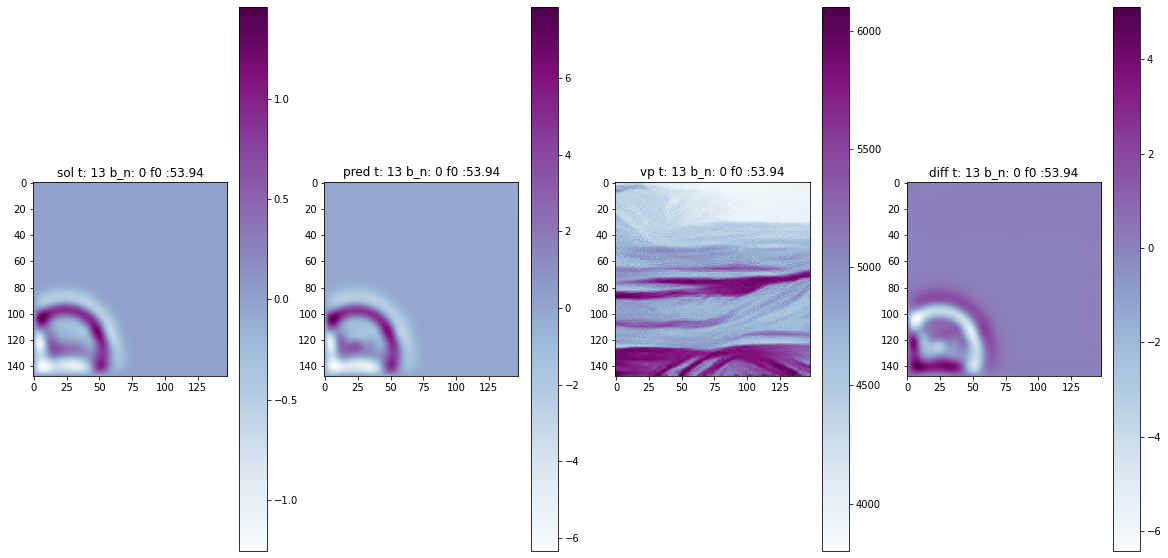

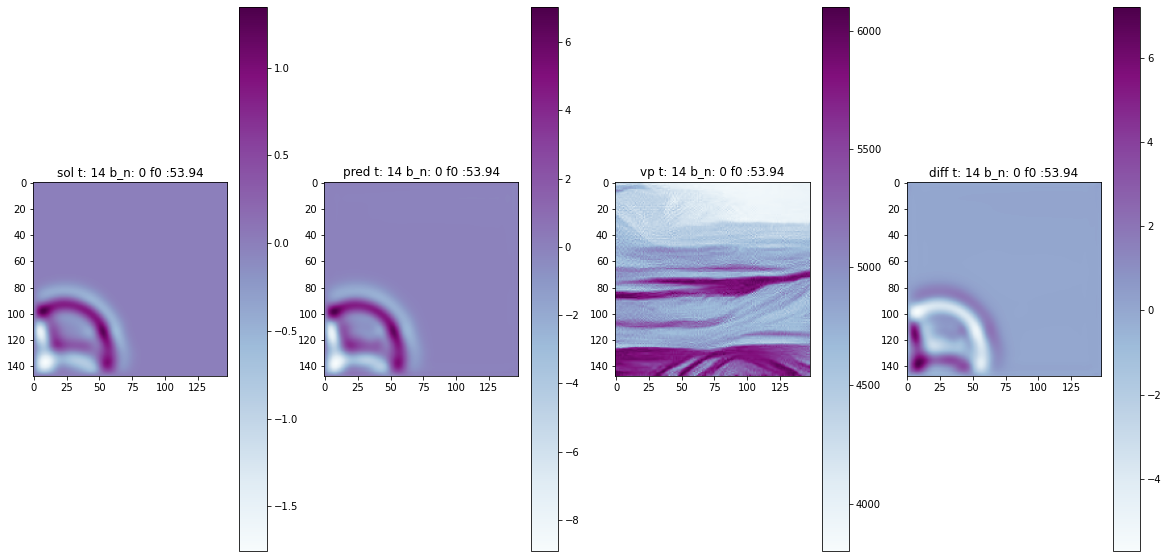

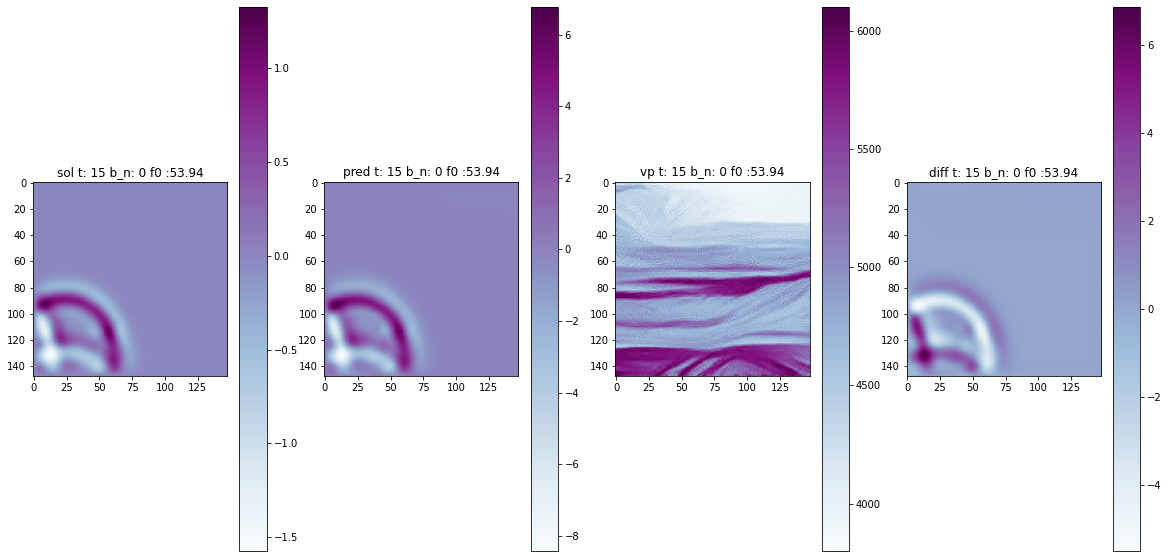

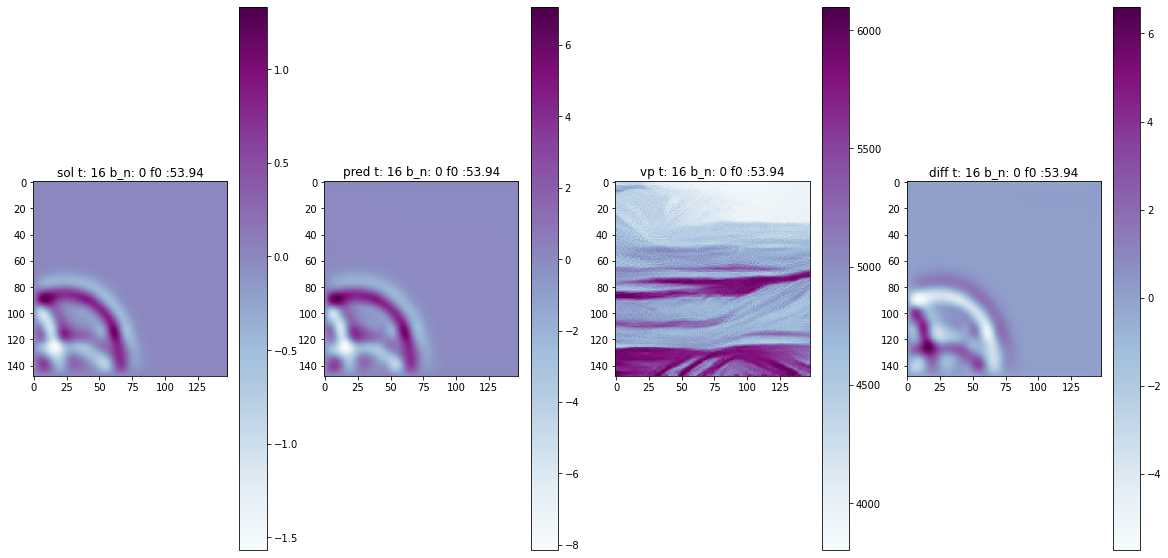

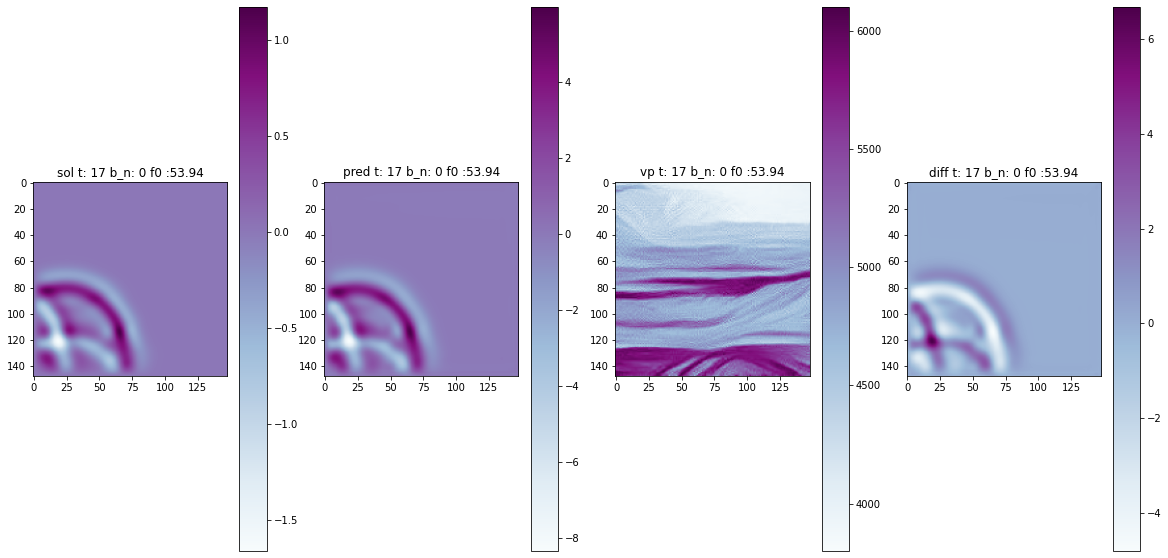

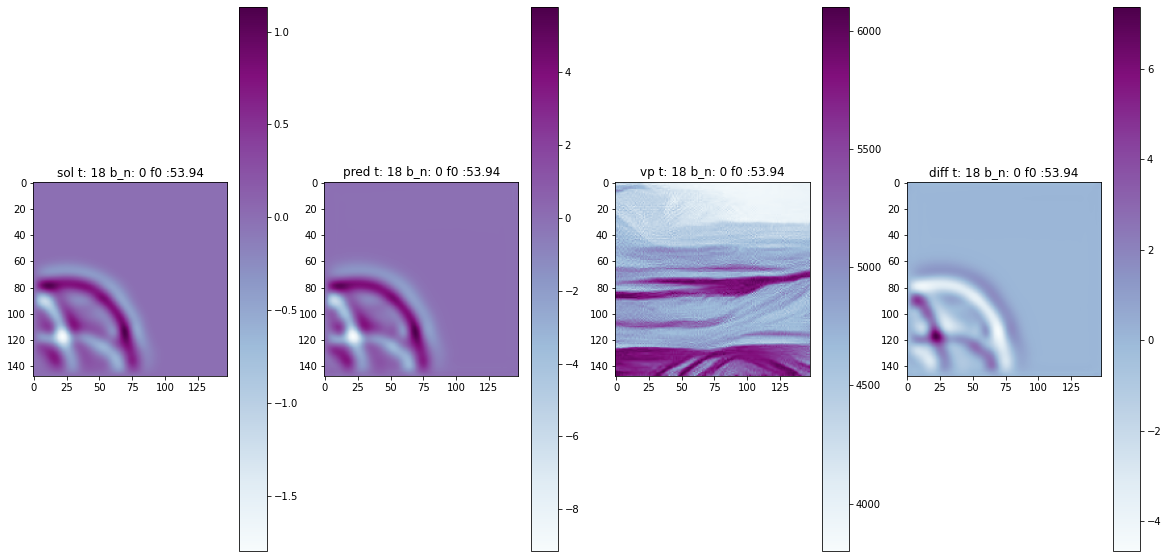

In [128]:
predictions, u_labels, vp, f0_list = test_diff_model__(model, N_min=4, N_max=6, nx=148, nz=148, nt=20, batch_size=2, device=device)
plot_test_video(u_labels, predictions, vp, f0_list)

In [ ]:
del predictions, u_labels, vp, f0_list

gc.collect()
torch.cuda.empty_cache()

NameError: ignored